In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP
import HDF5

In [2]:
include("../model-35-rot/likelihood.jl")
include("../model-35-rot/utill_model.jl")
include("../utill.jl")

plot_projections (generic function with 1 method)

In [3]:
function hist_2d(smpls, dim_1, dim_2; nbins=40, axmin = true, axmax=true)
    smpl_tmp, smpl_w = flatview(unshaped.(smpls.v)), smpls.weight
    if axmin == true
        hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), nbins=nbins)
    else
       hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), (range(axmin[1], stop=axmax[1], length=nbins), range(axmin[2], stop=axmax[2], length=nbins))) 
    end
    hist_tmp = normalize(hist_tmp, mode=:pdf) 
    return hist_tmp
end

hist_2d (generic function with 1 method)

In [4]:
β1= 0.015
β2 = 0.0077
β3 = 0.0058 

prior_1 = NamedTupleDist(
    tr_size = [truncated(Normal(0.2, 0.04), 0.05, 0.20), truncated(Normal(0.2, 0.04), 0.05, 0.20)],
    ang_spr = [truncated(Normal(4.0, 2.0), 3.0, 6.0), truncated(Normal(4.0, 2.0), 3.0, 6.0)],
    waist = [Normal(2.9, 0.03),],
    algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
    algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
    cam4_ped = 4.0 .. 40.0,
    cam4_light_fluct = 1.0 .. 3.0,
    cam4_light_amp = 1.6 .. 9.9, 
    resx = [1.0, 1.0, 1.0], 
    resy = [1.0, 1.0, 1.0], 
    cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
    cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
    psx = [27.1, 21.6, 114.0], # 31, 32, 33
    psy = [30.5, 23.4, 125.0], # 34, 35, 36
    cam4_psx = 121.8, # 37
    cam4_psy = 120.0, # 38
    light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
    s_cam = [0.0, 1.478, 15.026, 23.1150],
); 

prior_2 = NamedTupleDist(
    tr_size = [truncated(Normal(0.2, 0.04), 0.05, 0.20), truncated(Normal(0.2, 0.04), 0.05, 0.20)],
    ang_spr = [truncated(Normal(4.0, 2.0), 3.0, 6.0), truncated(Normal(4.0, 2.0), 3.0, 6.0)],
    waist = [Normal(2.9, 0.03),],
    α = -pi/4 .. pi/4,
    algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
    algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
    cam4_ped = 4.0 .. 40.0,
    cam4_light_fluct = 1.0 .. 3.0,
    cam4_light_amp = 1.6 .. 9.9, 
    resx = [1.0, 1.0, 1.0], 
    resy = [1.0, 1.0, 1.0], 
    cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
    cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
    psx = [27.1, 21.6, 114.0], # 31, 32, 33
    psy = [30.5, 23.4, 125.0], # 34, 35, 36
    cam4_psx = 121.8, # 37
    cam4_psy = 120.0, # 38
    light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
    s_cam = [0.0, 1.478, 15.026, 23.1150],
); 

prior_3 = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.06, 0.19), truncated(Normal(0.2, 0.04), 0.06, 0.19)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.06, 0.19), truncated(Normal(0.2, 0.04), 0.06, 0.19)],
        ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
        mixt_pow =  0.5 .. 1.0 ,
        waist = [truncated(Normal(2.9, 0.03), 2.65, 3.5)],
        waist_2 = [truncated(Normal(2.9, 0.03), 2.65, 3.5)], # 11
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
)

prior_4 = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.06, 0.19), truncated(Normal(0.2, 0.04), 0.06, 0.19)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.06, 0.19), truncated(Normal(0.2, 0.04), 0.06, 0.19)],
        ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
        mixt_pow =  0.5 .. 1.0 ,
        waist = [truncated(Normal(2.9, 0.03), 2.65, 3.5)],
        waist_2 = [truncated(Normal(2.9, 0.03), 2.65, 3.5)], # 11
        α = -pi/4 .. pi/4,
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
);

In [5]:
FPATH = "../../data/sampling_results/Benchmark-11/"

"../../data/sampling_results/Benchmark-11/"

In [15]:
smpl_tmp = bat_read(FPATH*"samples-35.hdf5").result
samples_1 = varshape(prior_1).(smpl_tmp);

smpl_tmp = bat_read(FPATH*"samples-rot-35.hdf5").result
samples_2 = varshape(prior_2).(smpl_tmp);

smpl_tmp = bat_read(FPATH*"samples-41.hdf5").result
samples_3 = varshape(prior_3).(smpl_tmp);

smpl_tmp = bat_read(FPATH*"samples-rot-41-fixed-good.hdf5").result
samples_4 = varshape(prior_4).(smpl_tmp);

In [16]:
length(samples_1)

881417

In [17]:
mode(samples_1)[1]

(tr_size = [0.10784726303387168, 0.1426415014455409], ang_spr = [4.796869587665877, 4.445544113334684], waist = [3.24210174853797], algmx = [31.737415755009394, 32.23066548640506, 21.26139030407421, 35.2534530376665], algmy = [36.92622511034586, 37.42457175590023, 20.188391142584358, 33.83949340406579], cam4_ped = 33.6358233306655, cam4_light_fluct = 1.9917222773885441, cam4_light_amp = 8.399733638388721, resx = [1.0, 1.0, 1.0], resy = [1.0, 1.0, 1.0], cam4_resx = 5.318821341530038, cam4_resy = 5.163767061208985, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [8.294569080975972, 11.463975424285767, 2.5549201411252334], s_cam = [0.0, 1.478, 15.026, 23.115])

In [18]:
mean(samples_2)[1]

(tr_size = [0.10715672642433144, 0.14123940942273755], ang_spr = [4.755298567016448, 4.427480527427697], waist = [3.2751472263835355], α = -0.041770013153476435, algmx = [29.96943095070808, 30.523781679682916, 20.316354304081145, 33.83107036884568], algmy = [38.08092651922387, 38.633768590832716, 20.98086551224679, 35.3052159583233], cam4_ped = 33.52721762798571, cam4_light_fluct = 2.0126315011350187, cam4_light_amp = 8.402985086121205, resx = [1.0, 1.0, 1.0], resy = [1.0, 1.0, 1.0], cam4_resx = 5.408805878839579, cam4_resy = 5.203971946567474, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [8.287477898762063, 11.446981307796015, 2.572804375803332], s_cam = [0.0, 1.478, 15.026, 23.115])

In [19]:
mode(samples_3)[1]

(tr_size = [0.0942948235312145, 0.13660776347192735], tr_size_2 = [0.1325250282650195, 0.15167408071500257], ang_spr = [6.170739004304787, 5.715760172903662], ang_spr_2 = [2.5674672998143864, 2.359452452143278], mixt_pow = 0.6711040166412797, waist = [3.085312875674748], waist_2 = [2.854797429700883], algmx = [31.736079839389664, 32.210230402934165, 21.326199695524398, 35.22188020124399], algmy = [36.92301992545441, 37.44339635656509, 20.23774773504772, 33.90286182582228], cam4_ped = 27.7645392452272, cam4_light_fluct = 1.3568000401169082, cam4_light_amp = 8.82343023228403, resx = [1, 1, 1], resy = [1, 1, 1], cam4_resx = 4.835751345410444, cam4_resy = 4.757896668725583, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [8.513975620414366, 11.421091511056494, 2.6846272899840624], s_cam = [0.0, 1.478, 15.026, 23.115])

In [20]:
mode(samples_4)[1]

(tr_size = [0.09149117125715514, 0.1339290910421858], tr_size_2 = [0.13236453440044527, 0.15289598308342364], ang_spr = [6.151568372634376, 5.7061865931087565], ang_spr_2 = [2.5335433003237893, 2.3354372884663714], mixt_pow = 0.6714310831959037, waist = [3.1206222671410964], waist_2 = [2.8730455325490944], α = -0.03052062046260907, algmx = [30.43421120788449, 30.95493313954944, 20.63117009687498, 34.20065461012066], algmy = [37.77026561538634, 38.30352475101947, 20.801731073328664, 34.976879323865845], cam4_ped = 27.840655954752876, cam4_light_fluct = 1.3726236285797024, cam4_light_amp = 8.821909895683378, resx = [1, 1, 1], resy = [1, 1, 1], cam4_resx = 4.89509396291918, cam4_resy = 4.786955549927975, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [8.500407299955937, 11.437198204414369, 2.6922018097425626], s_cam = [0.0, 1.478, 15.026, 23.115])

In [21]:
function plot_contours(ax, hist; kwargs...)
    ax.contour(midpoints(hist.edges[1]), midpoints(hist.edges[2]), hist.weights', 
        levels=range(minimum(hist.weights'), maximum(hist.weights'), length=11)[2:end], #corner_mask= true,
        colors="C0", alpha=0.8, antialiased=true) 
end

plot_contours (generic function with 1 method)

In [22]:
hist_1 = hist_2d(samples_1, 1,2)

hist_2 = hist_2d(samples_2, 1,2)

hist_3_1 = hist_2d(samples_3, 1,2)
hist_3_2 = hist_2d(samples_3, 3,4)

hist_4_1 = hist_2d(samples_4, 1,2)
hist_4_2 = hist_2d(samples_4, 3,4);

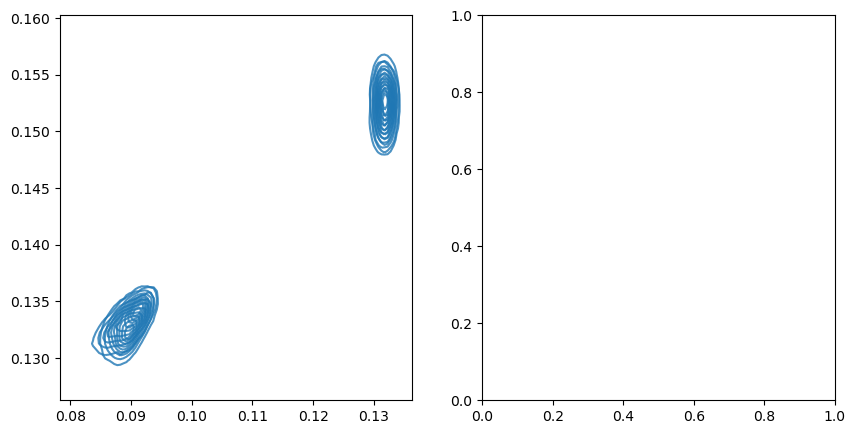

PyObject <matplotlib.contour.QuadContourSet object at 0x7fb046e26fa0>

In [23]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

# plot_contours(ax[1], hist_1)
# plot_contours(ax[1], hist_2)
plot_contours(ax[1], hist_3_1)
plot_contours(ax[1], hist_3_2)
plot_contours(ax[1], hist_4_1)
plot_contours(ax[1], hist_4_2)

In [ ]:
samples_2.v.α

In [ ]:
hist_tmp = fit(Histogram, samples_2.v.α, FrequencyWeights(samples_2.weight), range(-pi, stop=pi, length=150))
hist_tmp = normalize(hist_tmp, mode=:pdf)

In [ ]:
fig = figure(figsize=(7,7))

ax = PyPlot.axes(polar="true") # Create a polar axis


ax.plot(midpoints(hist_tmp.edges[1]), 
    hist_tmp.weights, 
    lw=1.2,  "o-", 
    color= plt.cm.hot_r(0.8), #"k", #plt.cm.hot_r(charge_n[i]), 
    alpha=0.4, 
    marker="None") 



ax.grid(alpha=0.2)
ax.set_yticklabels([])
# ax.set_xlim(-pi/50, 0)
ax.set_title("Azimuthal Angle Probability φ")

In [ ]:
dims = [1,2,3,4,5,6,]
names = dims
levels = [0.0001, 0.65, 0.9, 0.95,  1,]
levels = [0.01, 0.95, 1,]
figsize = (12,12)
n_bins = 20

corner_plots(samples_2, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = 7:14
names = dims
levels = [0.0001, 0.65, 0.9, 0.95,  1,]
levels = [0.01, 0.95, 1,]
figsize = (12,12)
n_bins = 20

corner_plots(samples_2, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = 7:22
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.01,  0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples_4, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = 20:27
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
plt.imshow(log.(abs.(cov(flatview(unshaped.(samples_4.v))'))), cmap="Blues")

In [ ]:
dt_reg = flatview(unshaped.(samples_4.v)) ./ std(flatview(unshaped.(samples_4.v)), dims=2)
dt_reg = dt_reg .- mean(dt_reg, dims=2)
dt_reg = cov(dt_reg')
max = maximum(abs.(dt_reg))

plt.imshow(dt_reg, cmap="seismic", vmin=-max, vmax=max)

In [ ]:
if true
    
    conv_mat = load("../../data/experiment/dataset_2/m2/conv-matrix-upd-2.jld2") 

    global conv_matrices = (
        cam_1 = conv_mat["cam_1"],
        cam_2 = conv_mat["cam_2"],
        cam_3 = conv_mat["cam_3"],
        cam_4 = conv_mat["cam_4"], 
    ) 

    images = load("../../data/experiment/dataset_2/m2/images-satur.jld2")
    event_number = 2

    global event = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );
    
    images = load("../../data/experiment/dataset_2/m2/images.jld2")

    global event_nt = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );
end

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

In [ ]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples_4)[1], mean(samples_2)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

In [ ]:
# include("../model-35-rot/likelihood.jl")
# include("../model-35-rot/utill_model.jl")
# include("../utill.jl")

include("../model-35/likelihood.jl")
include("../model-35/utill_model.jl")
include("../utill.jl")

In [ ]:
colors_array = ["C0", "C1"]
labels_array = ["samples_1", "samples_2"]
params_array = [mode(samples_1)[1], mode(samples_2)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

In [ ]:
params_array = [mode(samples_2)[1],]
colors_array = ["gray",]
labels_array = ["Truth", ]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

In [ ]:
plot_projections(conv_matrices, event_nt, event_nt, params_array[1], isnontr = true)